## Import Libraries

In [1]:
# TODO: Make all necessary imports.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
print(tf.__version__)

2.4.1


In [3]:
def get_files(base_dir, target_dir):
    count = 0
    path = get_path(base_dir, target_dir)
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            count+=len(glob.glob(os.path.join(dirname, filename)))
        return path, count

def get_path(base_dir, target_dir):
    path = os.path.join(base_dir,target_dir)
    return path

## Directory Setup

In [4]:
base_dir = '../input/pneumonia-xray-images'
train_normal_dir = 'train/normal'
train_pneumonia_dir = 'train/opacity'
val_normal_dir = 'val/normal'
val_pneumonia_dir = 'val/opacity'
test_normal_dir = 'test/normal'
test_pneumonia_dir = 'test/opacity'

train_normal_path, train_normal_count = get_files(base_dir,train_normal_dir)
train_pneumonia_path, train_pneumonia_count = get_files(base_dir,train_pneumonia_dir)

val_normal_path, val_normal_count = get_files(base_dir,val_normal_dir)
val_pneumonia_path, val_pneumonia_count = get_files(base_dir,val_pneumonia_dir)

test_normal_path, test_normal_count = get_files(base_dir,test_normal_dir)
test_pneumonia_path, test_pneumonia_count = get_files(base_dir,test_pneumonia_dir)

print("No of Train Images: {}".format(train_normal_count + train_pneumonia_count))
print(" \u2022 No of Normal Images {}".format(train_normal_count))
print(" \u2022 No of Pneumonia Images {}".format(train_pneumonia_count))

print("No of Validation Images: {}".format(val_normal_count + val_pneumonia_count))
print(" \u2022 No of Normal Images {}".format(val_normal_count))
print(" \u2022 No of Pneumonia Images {}".format(val_pneumonia_count))

print("No of Test Images: {}".format(test_normal_count + test_pneumonia_count))
print(" \u2022 No of Normal Images {}".format(test_normal_count))
print(" \u2022 No of Pneumonia Images {}".format(test_pneumonia_count))


No of Train Images: 4192
 • No of Normal Images 1082
 • No of Pneumonia Images 3110
No of Validation Images: 1040
 • No of Normal Images 267
 • No of Pneumonia Images 773
No of Test Images: 624
 • No of Normal Images 234
 • No of Pneumonia Images 390


In [5]:
train_data = []
for filename in os.listdir(train_normal_path):
    train_data.append((os.path.join(train_normal_path,filename),0))

for filename in os.listdir(train_pneumonia_path):
    train_data.append((os.path.join(train_pneumonia_path,filename),1))

train_data = pd.DataFrame(train_data, columns=['image_path', 'label'], index=None)
train_data = train_data.sample(frac=1).reset_index(drop=True)
        
val_data = []
for filename in os.listdir(val_normal_path):
    val_data.append((os.path.join(val_normal_path,filename),0))

for filename in os.listdir(val_pneumonia_path):
    val_data.append((os.path.join(val_pneumonia_path,filename),1))
        
val_data = pd.DataFrame(val_data, columns=['image_path', 'label'], index=None)
        
test_data = []
for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path,filename),0))

for filename in os.listdir(test_pneumonia_path):
    test_data.append((os.path.join(test_pneumonia_path,filename),1))

test_data = pd.DataFrame(test_data, columns=['image_path', 'label'], index=None)

print("Train Data {}".format(train_data.shape))
print("Validation Data {}".format(val_data.shape))
print("Test Data {}".format(test_data.shape))

Train Data (4192, 2)
Validation Data (1040, 2)
Test Data (624, 2)


In [6]:
train_data

image_path  label
0     ../input/pneumonia-xray-images/train/opacity/p...      1
1     ../input/pneumonia-xray-images/train/opacity/p...      1
2     ../input/pneumonia-xray-images/train/opacity/p...      1
3     ../input/pneumonia-xray-images/train/normal/IM...      0
4     ../input/pneumonia-xray-images/train/opacity/p...      1
...                                                 ...    ...
4187  ../input/pneumonia-xray-images/train/opacity/p...      1
4188  ../input/pneumonia-xray-images/train/opacity/p...      1
4189  ../input/pneumonia-xray-images/train/opacity/p...      1
4190  ../input/pneumonia-xray-images/train/normal/IM...      0
4191  ../input/pneumonia-xray-images/train/opacity/p...      1

[4192 rows x 2 columns]

<AxesSubplot:>

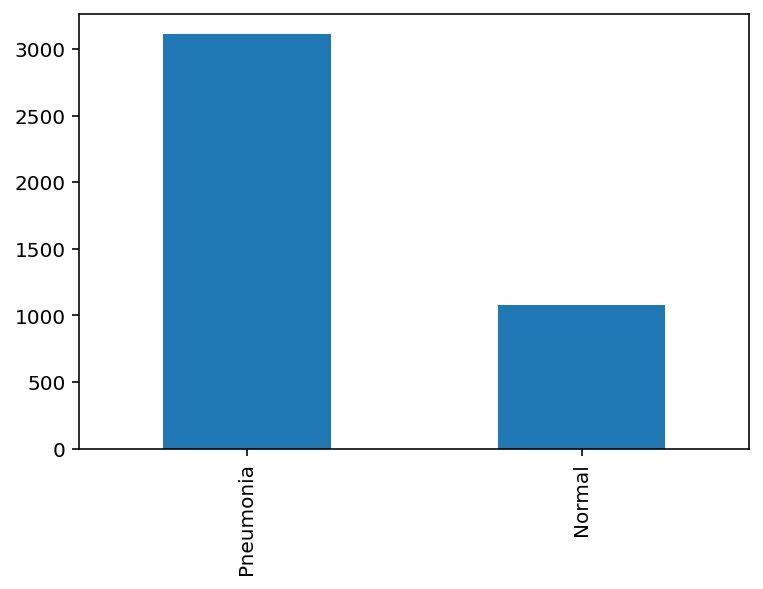

In [7]:
class_dict = {0:'Normal', 1:'Pneumonia'}
train_data['class_name'] = train_data.label.map(class_dict)
train_data['class_name'].value_counts().plot(kind='bar')

In [9]:
for filepath in train_data.image_path:
    image = cv2.imread(filepath)
    image_size = image.shape
    break
image_size

(1006, 1404, 3)

## Visualization

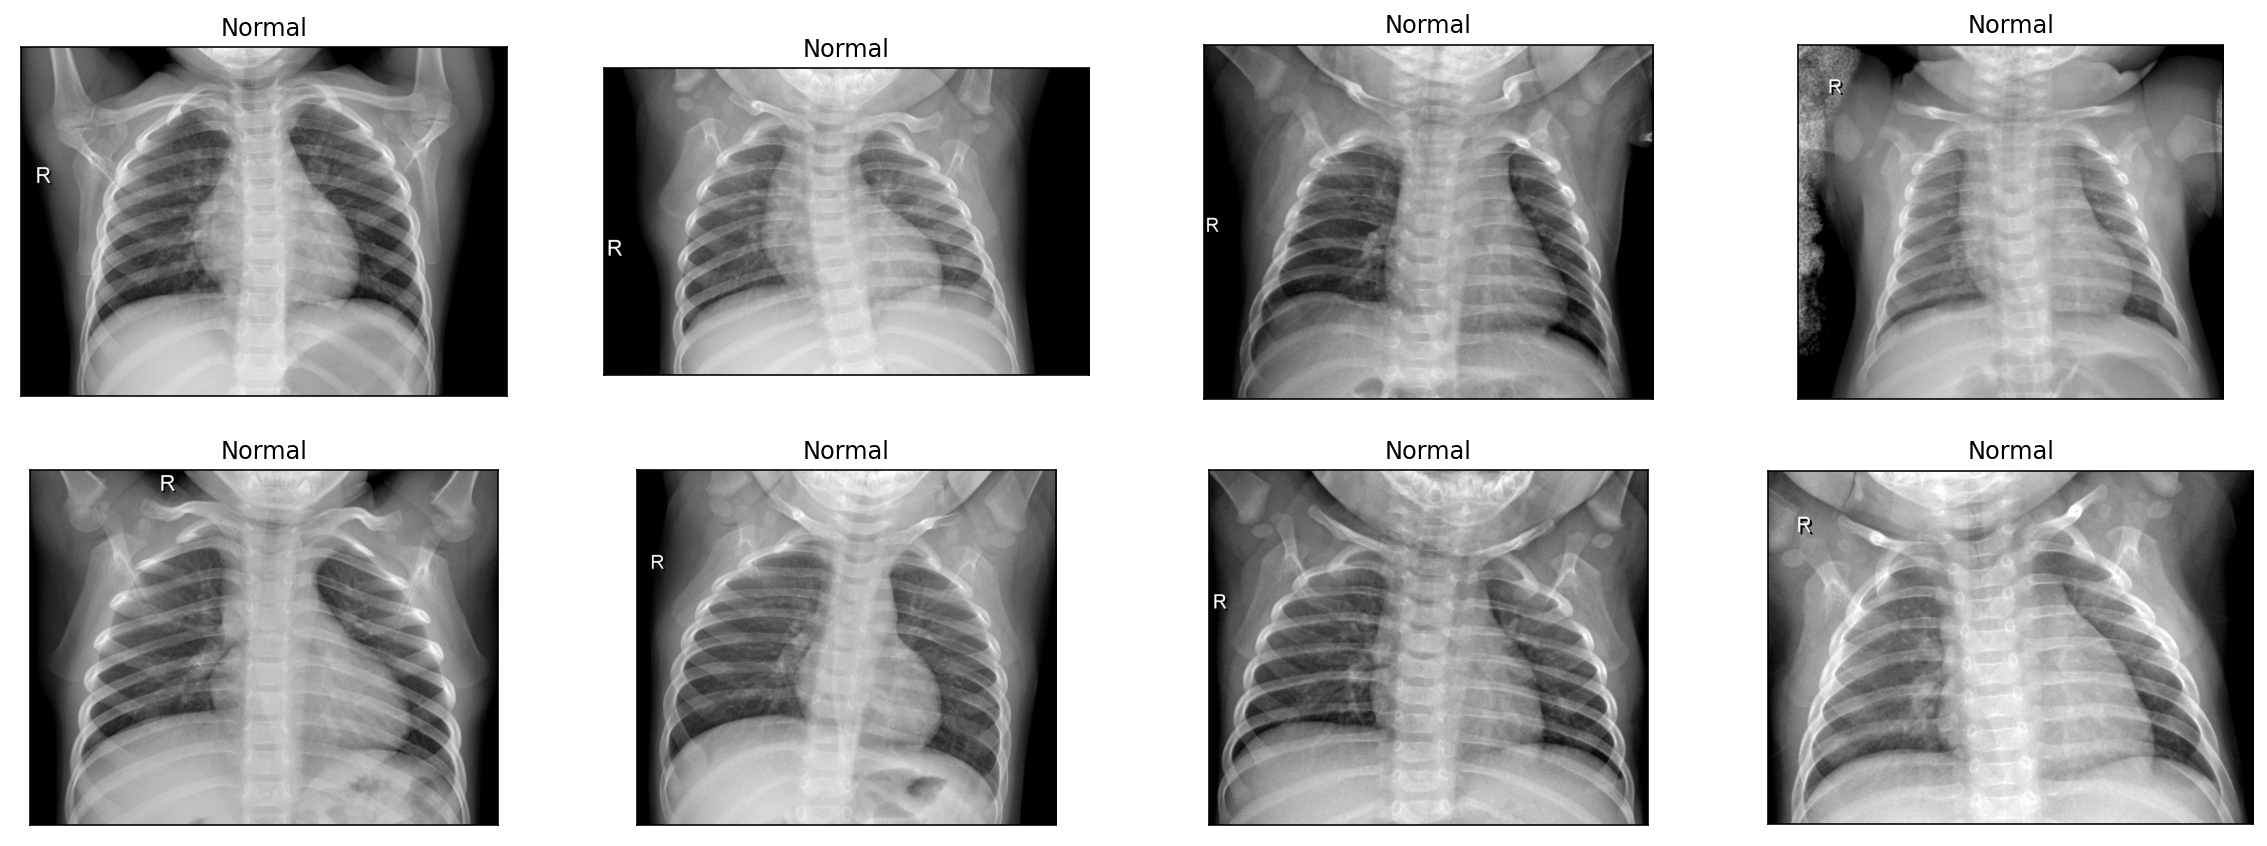

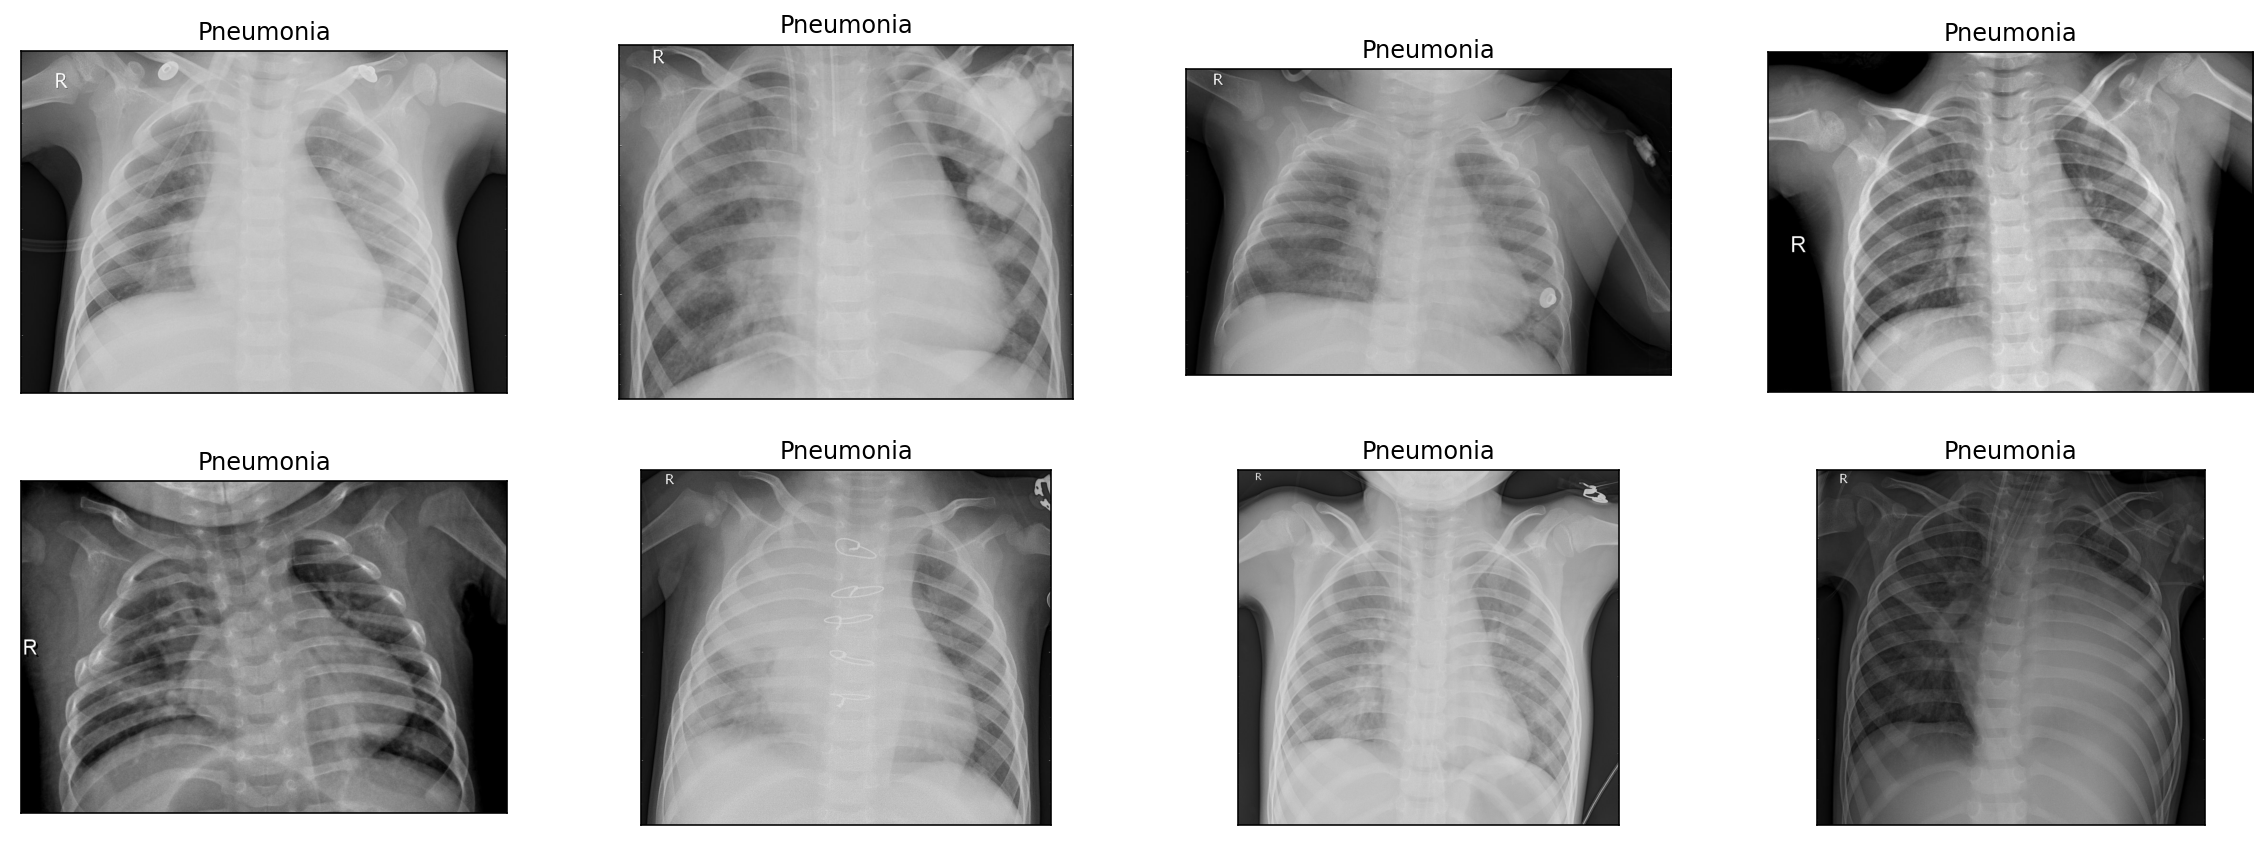

In [10]:
def visualize_img(images):
    fig = plt.figure(figsize=(20, 15))
    for i,path in enumerate(images):
        fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        img = cv2.imread(path)
        plt.imshow(img)
        plt.title(train_data[train_data.image_path == path].class_name.values[0])
        
for i in range(2):
    images = train_data[train_data.label == i].image_path
    images = np.random.choice(images , 8)
    visualize_img(images)

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

## Example of Data Augmentation

In [12]:
BATCH_SIZE = 32
IMG_SHAPE  = 224

train_image_gen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     brightness_range=[0.2,1.0],
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

train_gen = train_image_gen.flow_from_dataframe(train_data,
                                              x_col='image_path',
                                              y_col='class_name',
                                              class_mode='binary',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))

Found 4192 validated image filenames belonging to 2 classes.


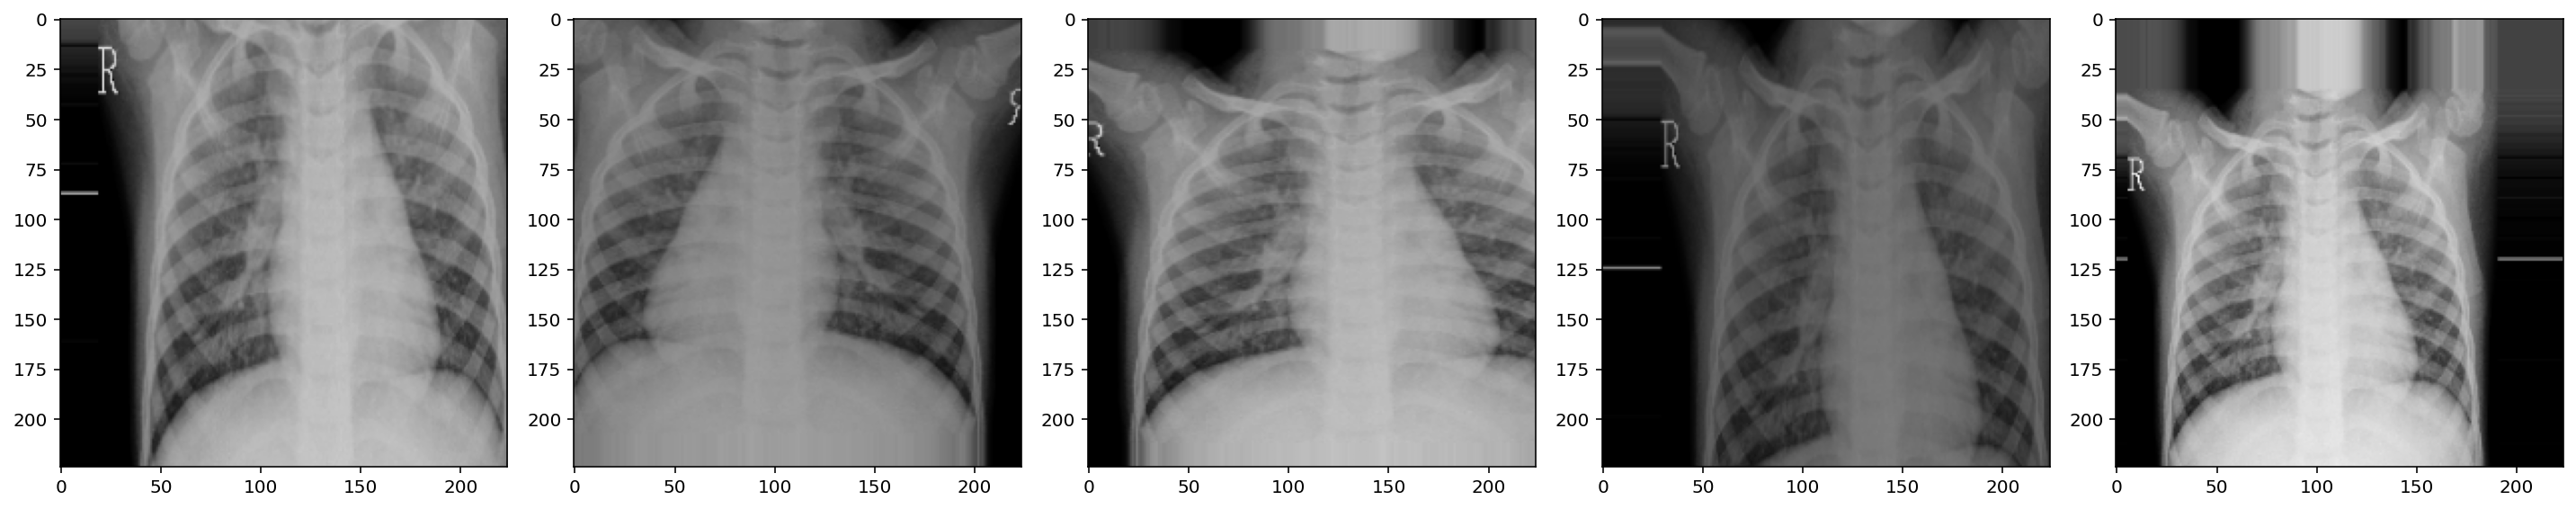

In [23]:
augmented_images = [train_gen[0][0][2] for i in range(5)]
plotImages(augmented_images)

## Data Preprocessing

In [24]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

train_lb = to_categorical(train_data.label, dtype = int)
val_lb = to_categorical(val_data.label, dtype=int)

train_data = train_data.reset_index().drop(labels='index', axis=1)
y_train = pd.DataFrame(train_lb).add_prefix('label_')

val_data = val_data.reset_index().drop(labels='index', axis=1)
y_val = pd.DataFrame(val_lb).add_prefix('label_')

train_data = pd.concat([train_data, y_train], axis=1)
val_data = pd.concat([val_data, y_val], axis=1)

print("Training set has {} samples".format(train_data.shape[0]))
print("Validation set has {} samples".format(val_data.shape[0]))

Training set has 4192 samples
Validation set has 1040 samples


## Helper Functions

In [25]:
BATCH_SIZE = 32
IMG_SHAPE  = 224
EPOCHS = 20

def gen():
    train_image_gen = ImageDataGenerator(rescale=1./255,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         brightness_range=[0.2,1.0],
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode='nearest')

    train_gen = train_image_gen.flow_from_dataframe(train_data,
                                              x_col='image_path',
                                              y_col=[f'label_{x}' for x in np.arange(2)],
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))


    val_image_gen = ImageDataGenerator(rescale=1./255)

    val_gen = val_image_gen.flow_from_dataframe(val_data,
                                              x_col='image_path',
                                              y_col= [f'label_{x}' for x in np.arange(2)],
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))
    return train_gen, val_gen


In [26]:
def plot(history):

    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(len(training_accuracy))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [27]:
from PIL import Image
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
def process_image(image):
    image = tf.cast(image , tf.float32)
    image = tf.image.resize(image , (224 , 224))
    image = image/255
    image = image.numpy()
    return image

## Model Building

1. **Baseline Model**

In [21]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      1040      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      4

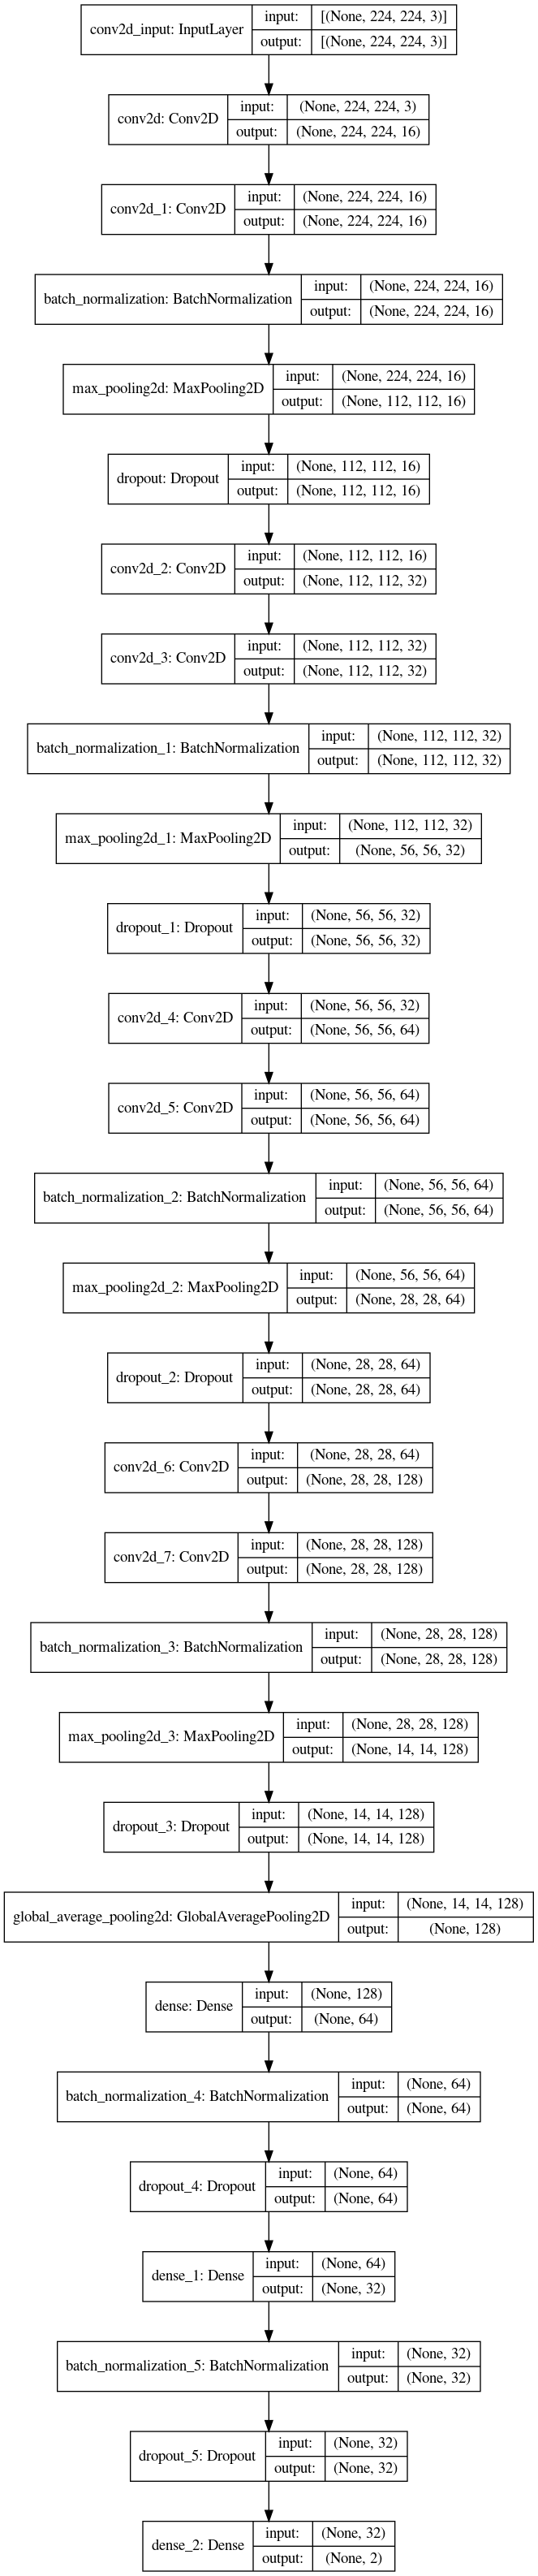

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='baseline_model.png', show_shapes=True, show_layer_names=True)

In [31]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_data['label']), train_data.label)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.9371534195933457, 1: 0.6739549839228296}

In [24]:
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

model_save = ModelCheckpoint('./baseline_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


base_history = model.fit(train_gen,
                             steps_per_epoch = train_gen.samples // BATCH_SIZE,
                             epochs = 20,
                             validation_data = val_gen,
                             callbacks=[EarlyStopping,model_save],
                             class_weight = class_weights)

Found 4192 validated image filenames.
Found 1040 validated image filenames.
Epoch 1/20
131/131 [==============================] - 182s 1s/step - loss: 0.9505 - accuracy: 0.5010 - val_loss: 0.6011 - val_accuracy: 0.7433

Epoch 00001: val_loss improved from inf to 0.60107, saving model to ./baseline_model.h5
Epoch 2/20
131/131 [==============================] - 112s 854ms/step - loss: 0.8220 - accuracy: 0.5523 - val_loss: 0.5757 - val_accuracy: 0.7433

Epoch 00002: val_loss improved from 0.60107 to 0.57566, saving model to ./baseline_model.h5
Epoch 3/20
131/131 [==============================] - 110s 839ms/step - loss: 0.7773 - accuracy: 0.5695 - val_loss: 1.1389 - val_accuracy: 0.7433

Epoch 00003: val_loss did not improve from 0.57566
Epoch 4/20
131/131 [==============================] - 112s 853ms/step - loss: 0.6884 - accuracy: 0.6244 - val_loss: 1.5069 - val_accuracy: 0.7433

Epoch 00004: val_loss did not improve from 0.57566
Epoch 5/20
131/131 [==============================] - 109

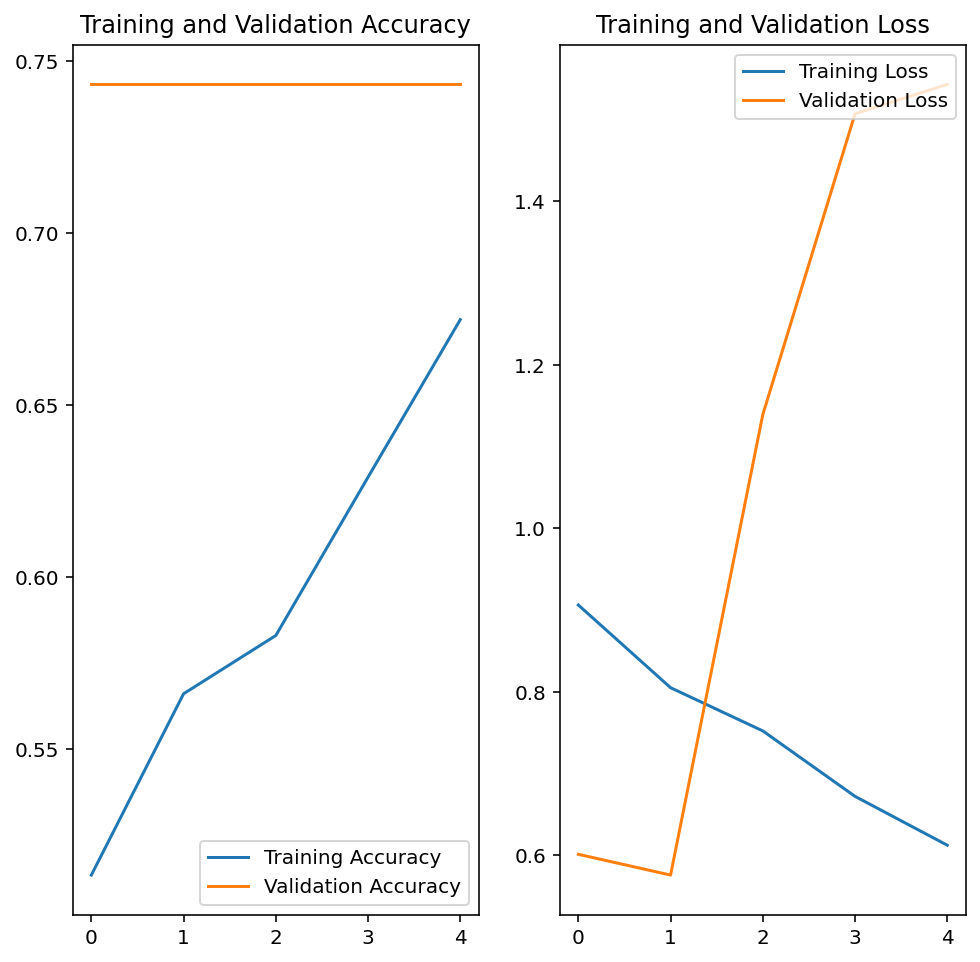

In [25]:
plot(base_history)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



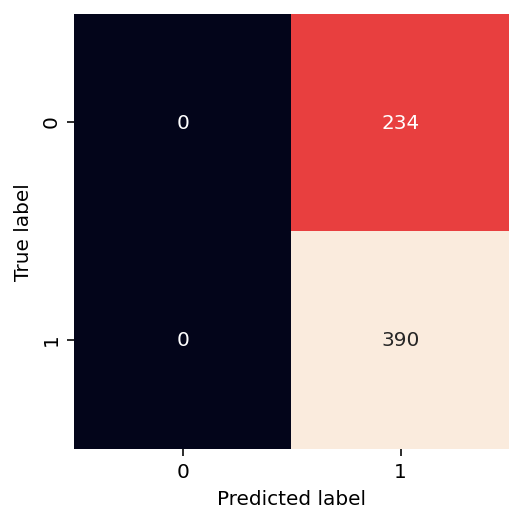

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


base_pred =[]
for image in test_data.image_path:
    base_pred.append(predict(image , model))
    
final_base_pred  = np.argmax(base_pred , axis=-1)
actual_label = test_data['label']

print(classification_report(actual_label, final_base_pred))
matrix=confusion_matrix(actual_label, final_base_pred)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');

2. **VGG16**

In [28]:
from tensorflow.keras.applications.vgg16 import VGG16

base = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable = False
    
vgg_model = Sequential()
vgg_model.add(base)
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(BatchNormalization())
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(BatchNormalization())
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(2, activation='softmax'))

vgg_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________

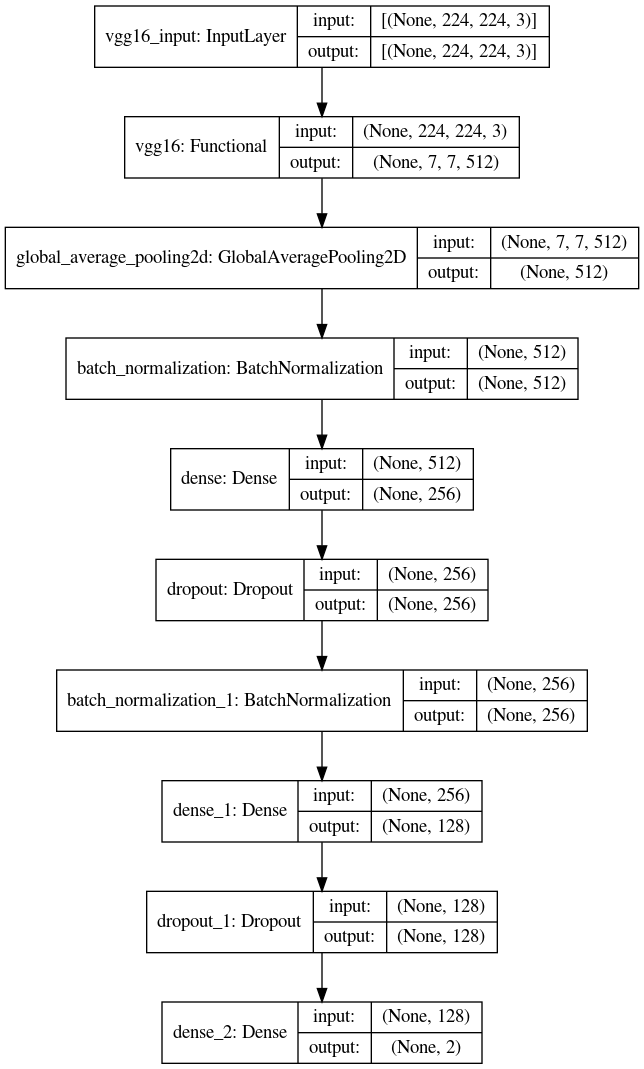

In [29]:
from keras.utils.vis_utils import plot_model
plot_model(vgg_model, to_file='vgg16_model.png', show_shapes=True, show_layer_names=True)

In [34]:
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
vgg_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

model_save = ModelCheckpoint('./vgg16_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


vgg_history = vgg_model.fit(train_gen,
                             steps_per_epoch = train_gen.samples // BATCH_SIZE,
                             epochs = 20,
                             validation_data = val_gen,
                             callbacks=[EarlyStopping, model_save],
                             class_weight = class_weights)

Found 4192 validated image filenames.
Found 1040 validated image filenames.
Epoch 1/20
131/131 [==============================] - 154s 1s/step - loss: 0.8175 - accuracy: 0.6022 - val_loss: 0.6654 - val_accuracy: 0.6798

Epoch 00001: val_loss improved from inf to 0.66541, saving model to ./vgg16_model.h5
Epoch 2/20
131/131 [==============================] - 96s 737ms/step - loss: 0.6610 - accuracy: 0.6953 - val_loss: 0.6565 - val_accuracy: 0.5587

Epoch 00002: val_loss improved from 0.66541 to 0.65652, saving model to ./vgg16_model.h5
Epoch 3/20
131/131 [==============================] - 97s 744ms/step - loss: 0.5702 - accuracy: 0.7364 - val_loss: 0.6720 - val_accuracy: 0.5452

Epoch 00003: val_loss did not improve from 0.65652
Epoch 4/20
131/131 [==============================] - 101s 770ms/step - loss: 0.5277 - accuracy: 0.7616 - val_loss: 0.5857 - val_accuracy: 0.6712

Epoch 00004: val_loss improved from 0.65652 to 0.58567, saving model to ./vgg16_model.h5
Epoch 5/20
131/131 [=======

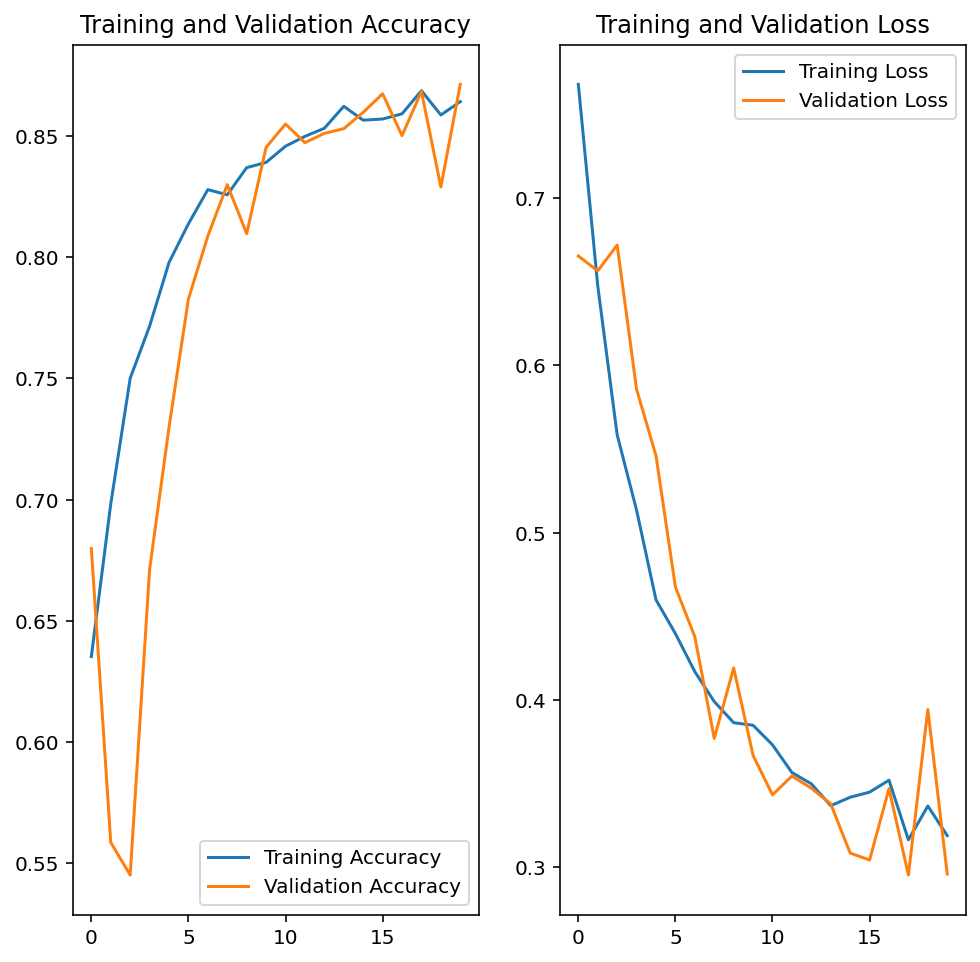

In [35]:
plot(vgg_history)

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       234
           1       0.93      0.84      0.88       390

    accuracy                           0.86       624
   macro avg       0.85      0.87      0.86       624
weighted avg       0.87      0.86      0.86       624



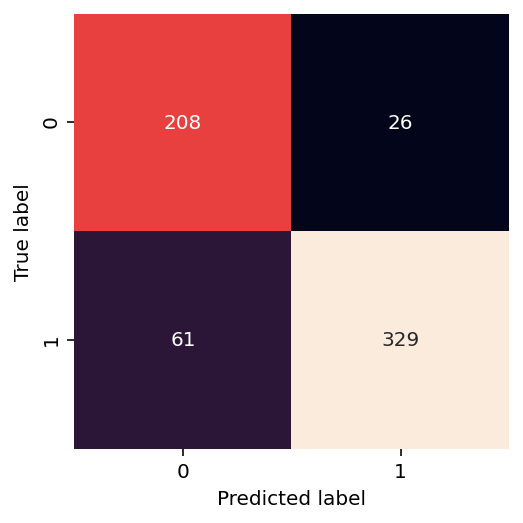

In [37]:
vgg_pred =[]
for image in test_data.image_path:
    vgg_pred.append(predict(image , vgg_model))
    
final_vgg_pred  = np.argmax(vgg_pred , axis=-1)
actual_label = test_data['label']

print(classification_report(actual_label, final_vgg_pred))
matrix=confusion_matrix(actual_label, final_vgg_pred)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');

In [39]:
print(vgg_history.history['val_accuracy'][-3])
print(vgg_history.history['val_loss'][-3])

0.8682692050933838
0.2951194941997528


3. **MobileNetV2**

In [40]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()
    
for layer in base.layers:
    layer.trainable =  False

mobilenet_model = Sequential()
mobilenet_model.add(base)
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(128, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(Dense(2, activation='softmax'))

mobilenet_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
___________________________________________________________

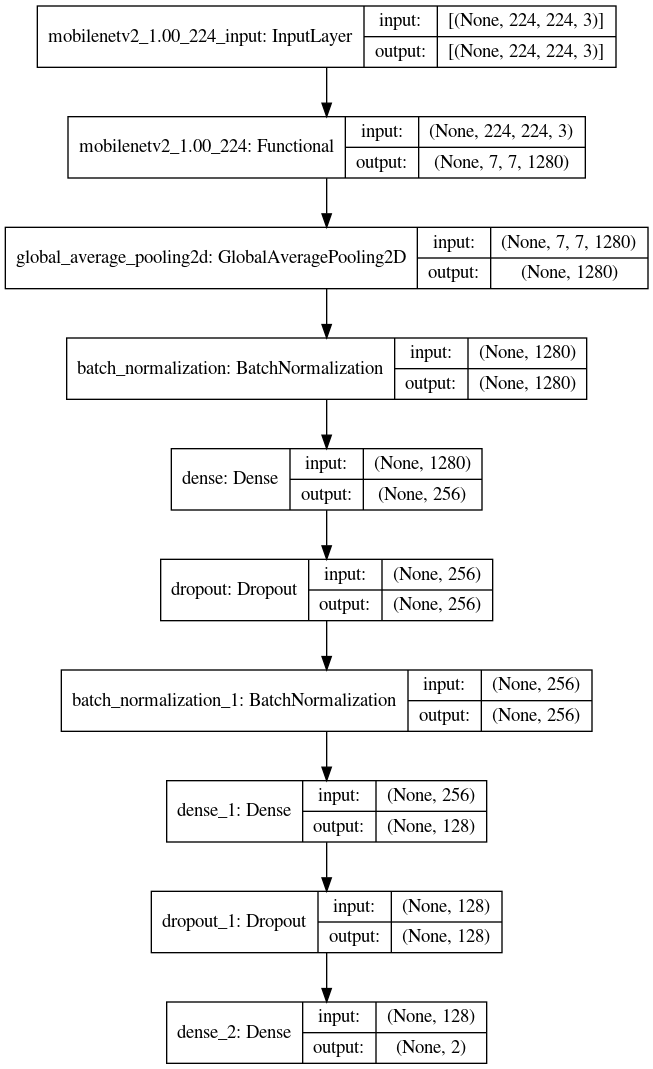

In [41]:
from keras.utils.vis_utils import plot_model
plot_model(mobilenet_model, to_file='mobilenet_model.png', show_shapes=True, show_layer_names=True)

In [44]:
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
mobilenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

model_save = ModelCheckpoint('./mobilenetV2.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


mob_history = mobilenet_model.fit(train_gen,
                              steps_per_epoch = train_gen.samples // BATCH_SIZE,
                              epochs = EPOCHS,
                              validation_data = val_gen,
                              callbacks=[EarlyStopping, model_save])

Found 4192 validated image filenames.
Found 1040 validated image filenames.
Epoch 1/20
131/131 [==============================] - 98s 730ms/step - loss: 0.7897 - accuracy: 0.6004 - val_loss: 0.4541 - val_accuracy: 0.8500

Epoch 00001: val_loss improved from inf to 0.45408, saving model to ./mobilenetV2.h5
Epoch 2/20
131/131 [==============================] - 94s 720ms/step - loss: 0.4763 - accuracy: 0.8183 - val_loss: 0.3734 - val_accuracy: 0.8462

Epoch 00002: val_loss improved from 0.45408 to 0.37338, saving model to ./mobilenetV2.h5
Epoch 3/20
131/131 [==============================] - 94s 717ms/step - loss: 0.3754 - accuracy: 0.8612 - val_loss: 0.2983 - val_accuracy: 0.8760

Epoch 00003: val_loss improved from 0.37338 to 0.29825, saving model to ./mobilenetV2.h5
Epoch 4/20
131/131 [==============================] - 94s 719ms/step - loss: 0.3288 - accuracy: 0.8731 - val_loss: 0.2885 - val_accuracy: 0.8721

Epoch 00004: val_loss improved from 0.29825 to 0.28847, saving model to ./mob

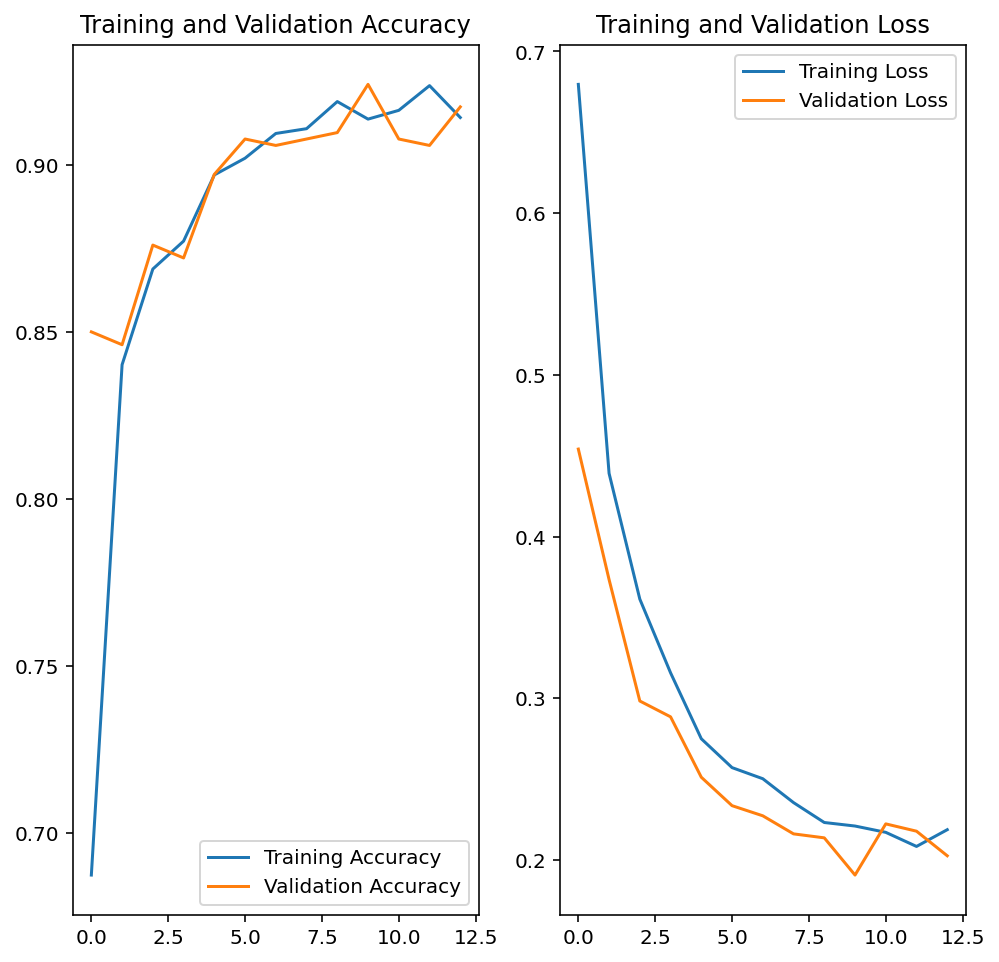

In [45]:
plot(mob_history)

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       234
           1       0.91      0.93      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



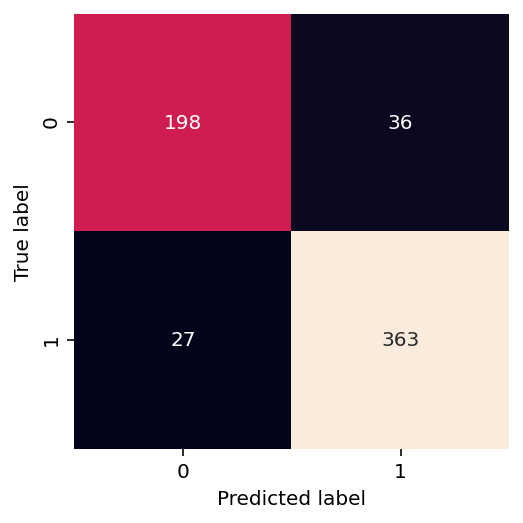

In [46]:
mob_pred =[]
for image in test_data.image_path:
    mob_pred.append(predict(image , mobilenet_model))
    
final_mob_pred  = np.argmax(mob_pred , axis=-1)
actual_label = test_data['label']

print(classification_report(actual_label, final_mob_pred))
matrix=confusion_matrix(actual_label, final_mob_pred)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');

In [47]:
print(mob_history.history['val_accuracy'][-4])
print(mob_history.history['val_loss'][-4])

0.9240384697914124
0.1905973255634308


4. **DenseNet169**

In [48]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

base = DenseNet169(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable =  False

densenet_model = Sequential()
densenet_model.add(base)
densenet_model.add(GlobalAveragePooling2D())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(2, activation='softmax'))

densenet_model.summary()

51879936/51877672 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1664)              6656      
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________

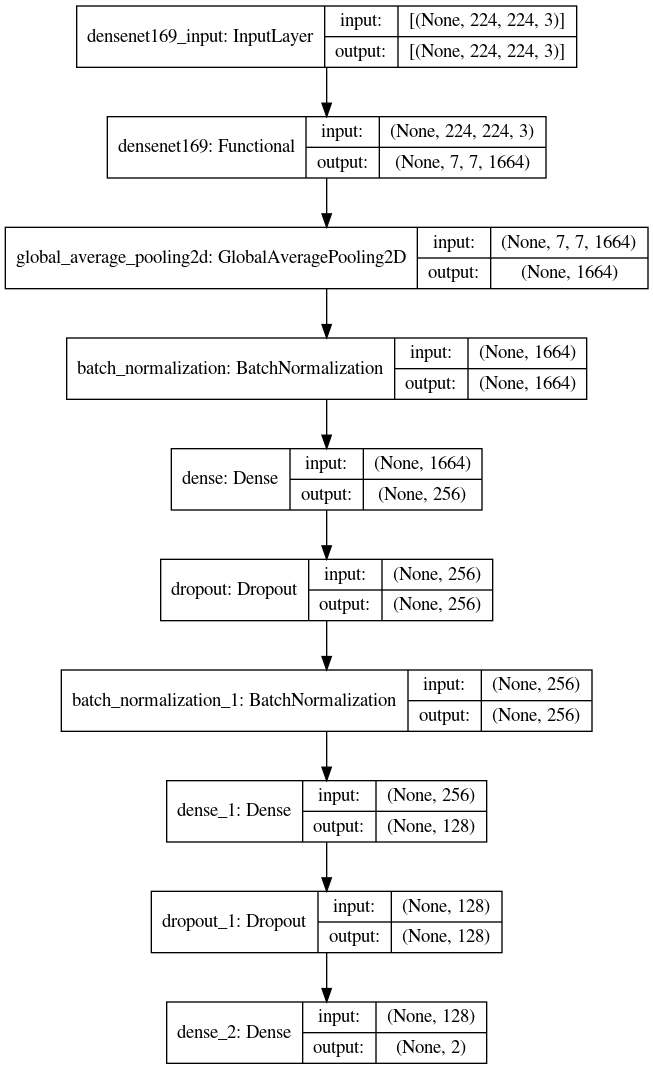

In [49]:
from keras.utils.vis_utils import plot_model
plot_model(densenet_model, to_file='densenet169_model.png', show_shapes=True, show_layer_names=True)

In [52]:
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
densenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

model_save = ModelCheckpoint('./densenet169.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


dense_history = densenet_model.fit(train_gen,
                              steps_per_epoch = train_gen.samples // BATCH_SIZE,
                              epochs = EPOCHS,
                              validation_data = val_gen,
                              callbacks=[EarlyStopping, model_save])

Found 4192 validated image filenames.
Found 1040 validated image filenames.
Epoch 1/20
131/131 [==============================] - 109s 768ms/step - loss: 0.8379 - accuracy: 0.5811 - val_loss: 0.4822 - val_accuracy: 0.8596

Epoch 00001: val_loss improved from inf to 0.48221, saving model to ./densenet169.h5
Epoch 2/20
131/131 [==============================] - 99s 755ms/step - loss: 0.4852 - accuracy: 0.8235 - val_loss: 0.2789 - val_accuracy: 0.9337

Epoch 00002: val_loss improved from 0.48221 to 0.27895, saving model to ./densenet169.h5
Epoch 3/20
131/131 [==============================] - 98s 743ms/step - loss: 0.3651 - accuracy: 0.8727 - val_loss: 0.2052 - val_accuracy: 0.9452

Epoch 00003: val_loss improved from 0.27895 to 0.20515, saving model to ./densenet169.h5
Epoch 4/20
131/131 [==============================] - 97s 744ms/step - loss: 0.3211 - accuracy: 0.8859 - val_loss: 0.1630 - val_accuracy: 0.9529

Epoch 00004: val_loss improved from 0.20515 to 0.16301, saving model to ./de

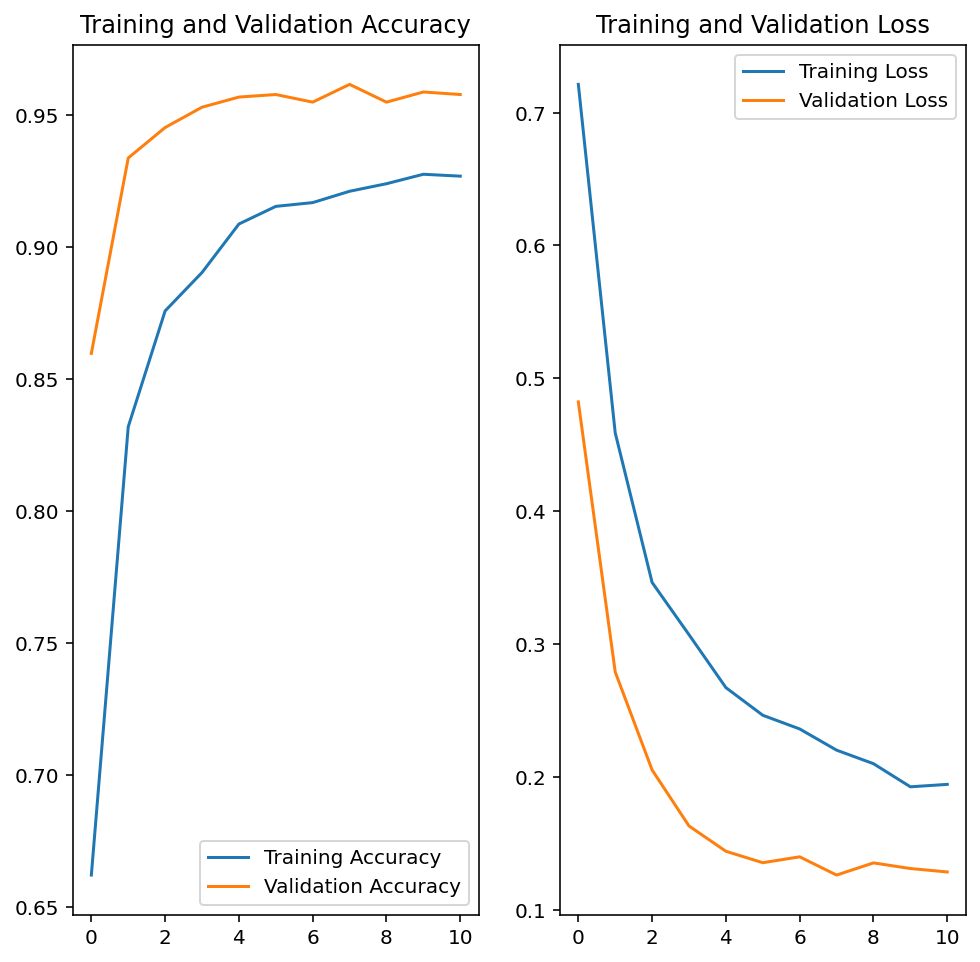

In [53]:
plot(dense_history)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       234
           1       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



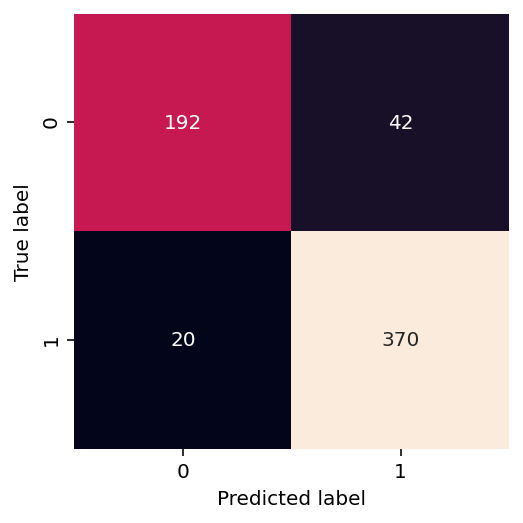

In [54]:
dense_pred =[]
for image in test_data.image_path:
    dense_pred.append(predict(image , densenet_model))
    
final_dense_pred  = np.argmax(dense_pred , axis=-1)
actual_label = test_data['label']

print(classification_report(actual_label, final_dense_pred))
matrix=confusion_matrix(actual_label, final_dense_pred)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');

In [55]:
print(dense_history.history['val_accuracy'][-4])
print(dense_history.history['val_loss'][-4])

0.9615384340286255
0.12605918943881989


## Baseline Ensemble

1. **MobileNetV2 + DenseNet169**

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       234
           1       0.91      0.96      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



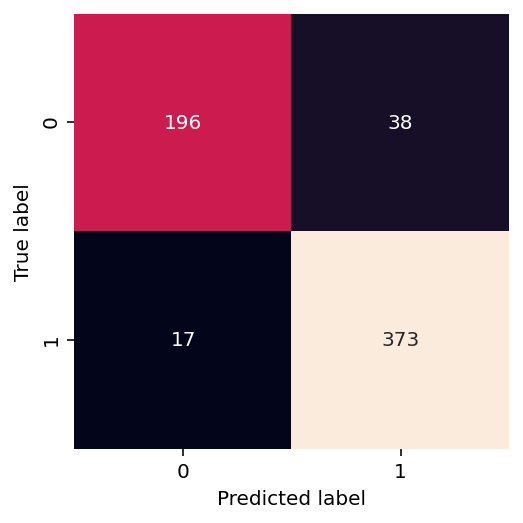

In [57]:
model1_list=[]
model2_list=[]

predicted_label_list=[]

for image in test_data.image_path:
    model1_list.append(predict(image, densenet_model))
    model2_list.append(predict(image, mobilenet_model))

for mob, dense in zip(model1_list, model2_list):
    predicted_label_list.append(np.argmax(mob/np.linalg.norm(mob) + dense/np.linalg.norm(dense)))

actual_label = test_data['label']
print(classification_report(actual_label, predicted_label_list))

matrix=confusion_matrix(actual_label, predicted_label_list)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');


2. **MobileNetV2 + DenseNet169 + VGG16**

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       234
           1       0.93      0.94      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624



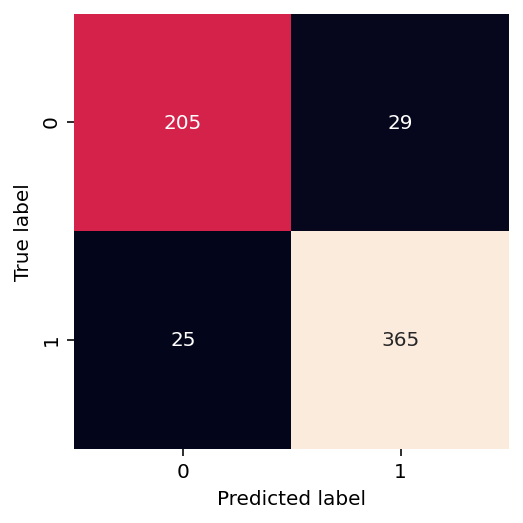

In [58]:
model1_list=[]
model2_list=[]
model3_list=[]

predicted_label_list=[]

for image in test_data.image_path:
    model1_list.append(predict(image, densenet_model))
    model2_list.append(predict(image, mobilenet_model))
    model3_list.append(predict(image, vgg_model))

for mob, dense, vgg in zip(model1_list, model2_list, model3_list):
    predicted_label_list.append(np.argmax(mob/np.linalg.norm(mob) + dense/np.linalg.norm(dense) + vgg/np.linalg.norm(vgg)))

actual_label = test_data['label']
print(classification_report(actual_label, predicted_label_list))

matrix=confusion_matrix(actual_label, predicted_label_list)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');


3. **VGG16 + MobileNetV2**

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       234
           1       0.94      0.92      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624



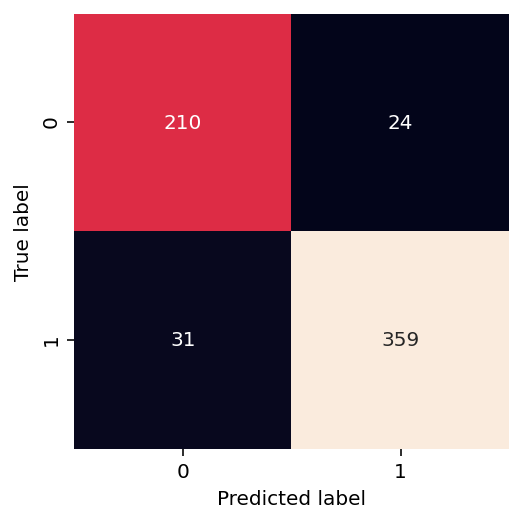

In [78]:
model1_list=[]
model2_list=[]

predicted_label_list=[]

for image in test_data.image_path:
    model1_list.append(predict(image, vgg_model))
    model2_list.append(predict(image, mobilenet_model))

for vgg, mob in zip(model1_list, model2_list):
    predicted_label_list.append(np.argmax(vgg/np.linalg.norm(vgg) + mob/np.linalg.norm(mob)))

actual_label = test_data['label']
print(classification_report(actual_label, predicted_label_list))

matrix=confusion_matrix(actual_label, predicted_label_list)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');


4. **VGG16 + DenseNet169**

              precision    recall  f1-score   support

           0       0.91      0.86      0.89       234
           1       0.92      0.95      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



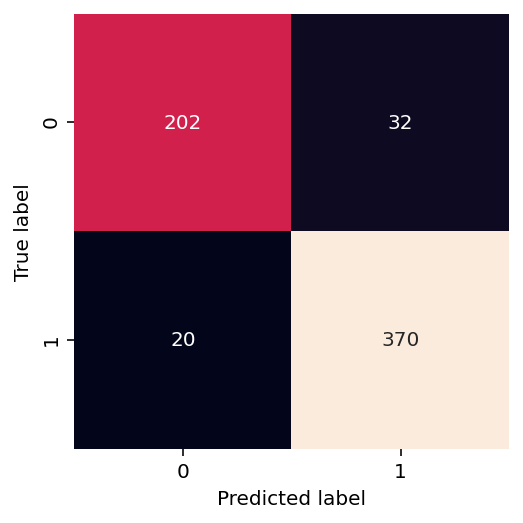

In [79]:
model1_list=[]
model2_list=[]

predicted_label_list=[]

for image in test_data.image_path:
    model1_list.append(predict(image, vgg_model))
    model2_list.append(predict(image, densenet_model))

for vgg, dense in zip(model1_list, model2_list):
    predicted_label_list.append(np.argmax(vgg/np.linalg.norm(vgg) + dense/np.linalg.norm(dense)))

actual_label = test_data['label']
print(classification_report(actual_label, predicted_label_list))

matrix=confusion_matrix(actual_label, predicted_label_list)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');


5. **InceptionV3**

In [68]:
from tensorflow.keras.applications import InceptionV3
base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()
for layer in base.layers:   
    layer.trainable = False

incept_model = Sequential()
incept_model.add(base)
incept_model.add(GlobalAveragePooling2D())
incept_model.add(BatchNormalization())
incept_model.add(Dense(256, activation='relu'))
incept_model.add(Dropout(0.5))
incept_model.add(BatchNormalization())
incept_model.add(Dense(128, activation='relu'))
incept_model.add(Dropout(0.5))
incept_model.add(Dense(2, activation='softmax'))

incept_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________

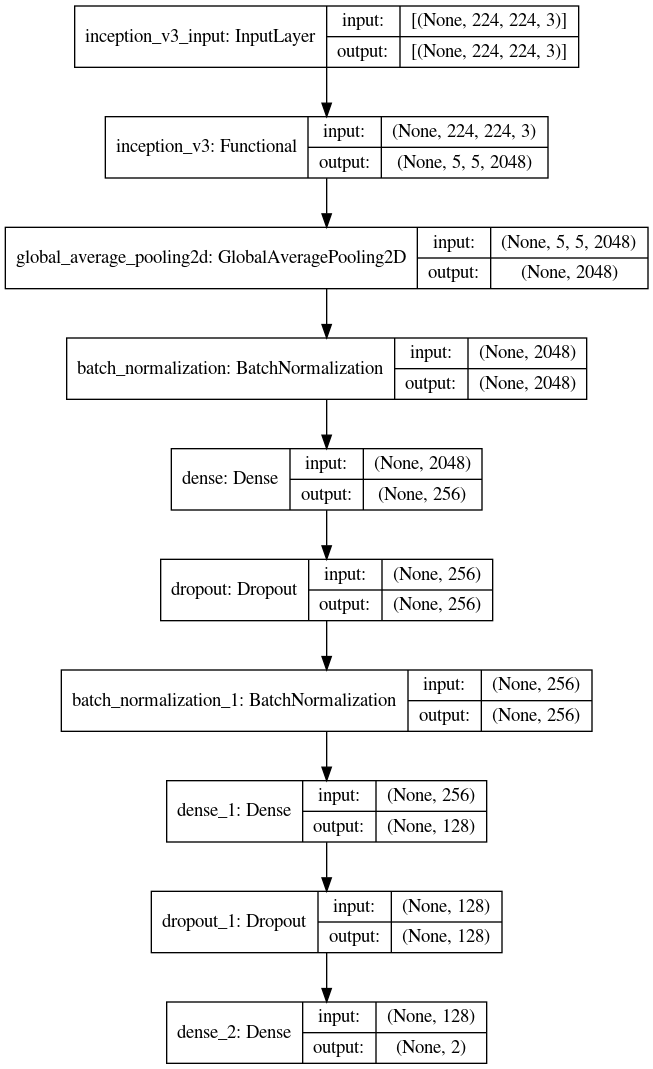

In [69]:
from keras.utils.vis_utils import plot_model
plot_model(incept_model, to_file='inceptionV3_model.png', show_shapes=True, show_layer_names=True)

In [72]:
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
incept_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

model_save = ModelCheckpoint('./inceptionV3.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


incept_history = incept_model.fit(train_gen,
                              steps_per_epoch = train_gen.samples // BATCH_SIZE,
                              epochs = EPOCHS,
                              validation_data = val_gen,
                              callbacks=[EarlyStopping, model_save])

Found 4192 validated image filenames.
Found 1040 validated image filenames.
Epoch 1/20
131/131 [==============================] - 102s 741ms/step - loss: 0.8389 - accuracy: 0.5565 - val_loss: 0.4376 - val_accuracy: 0.8510

Epoch 00001: val_loss improved from inf to 0.43757, saving model to ./inceptionV3.h5
Epoch 2/20
131/131 [==============================] - 96s 730ms/step - loss: 0.4806 - accuracy: 0.8190 - val_loss: 0.3199 - val_accuracy: 0.8904

Epoch 00002: val_loss improved from 0.43757 to 0.31991, saving model to ./inceptionV3.h5
Epoch 3/20
131/131 [==============================] - 95s 729ms/step - loss: 0.3748 - accuracy: 0.8638 - val_loss: 0.2753 - val_accuracy: 0.9010

Epoch 00003: val_loss improved from 0.31991 to 0.27534, saving model to ./inceptionV3.h5
Epoch 4/20
131/131 [==============================] - 95s 728ms/step - loss: 0.3201 - accuracy: 0.8842 - val_loss: 0.2437 - val_accuracy: 0.9048

Epoch 00004: val_loss improved from 0.27534 to 0.24369, saving model to ./in

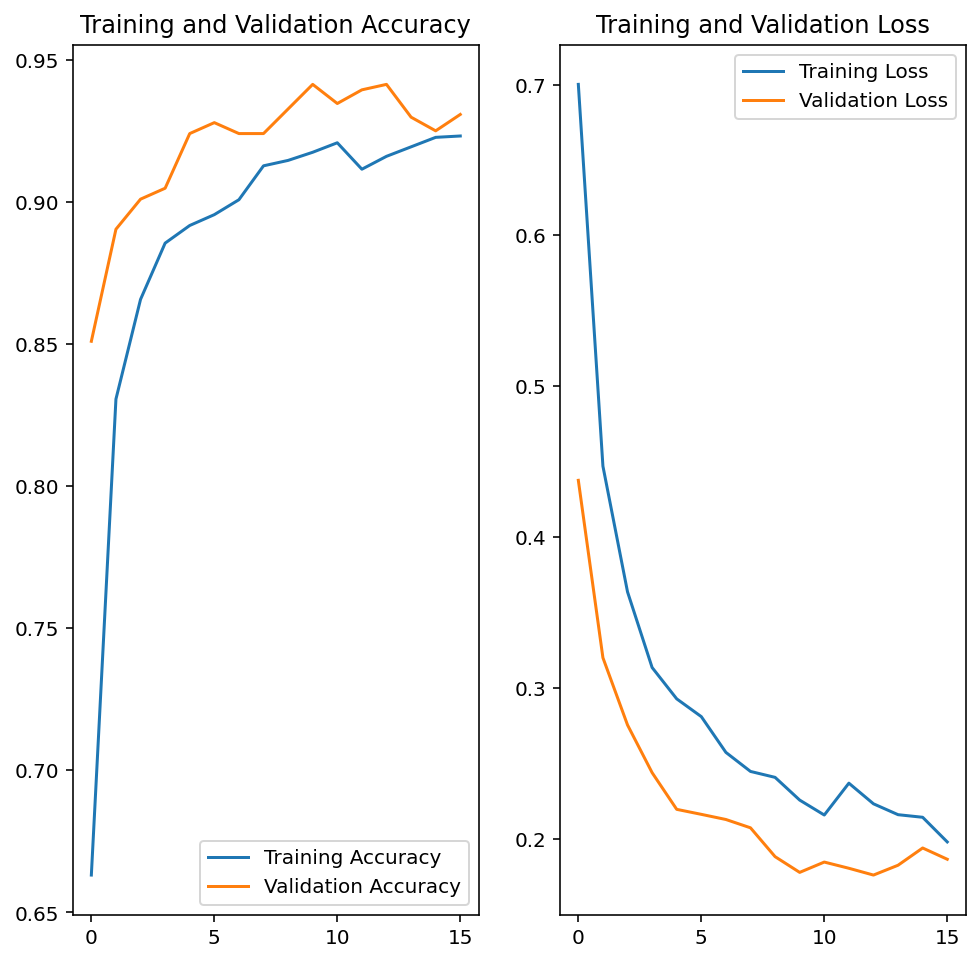

In [73]:
plot(incept_history)

              precision    recall  f1-score   support

           0       0.90      0.64      0.75       234
           1       0.81      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.81       624
weighted avg       0.85      0.84      0.83       624



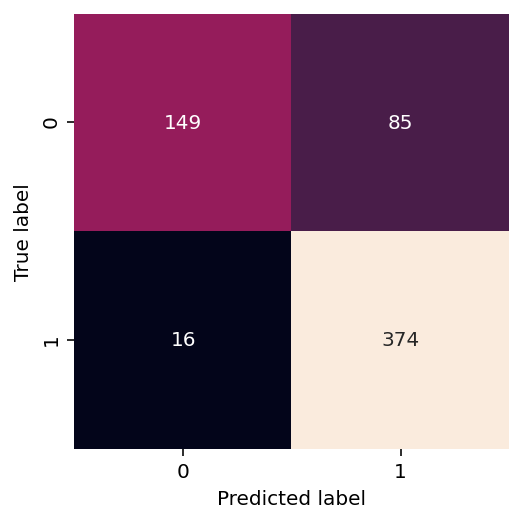

In [74]:
incept_pred =[]
for image in test_data.image_path:
    incept_pred.append(predict(image , incept_model))
    
final_incept_pred  = np.argmax(incept_pred , axis=-1)
actual_label = test_data['label']

print(classification_report(actual_label, final_incept_pred))
matrix=confusion_matrix(actual_label, final_incept_pred)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');

5. **MobileNetV2 + DenseNet169 + VGG16 + InceptionV3**

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       234
           1       0.91      0.96      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



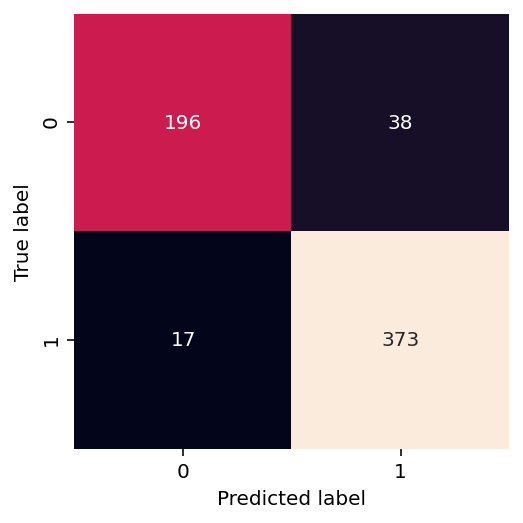

In [77]:
model1_list=[]
model2_list=[]
model3_list=[]
model4_list=[]

predicted_label_list=[]

for image in test_data.image_path:
    model1_list.append(predict(image, densenet_model))
    model2_list.append(predict(image, mobilenet_model))
    model3_list.append(predict(image, vgg_model))
    model4_list.append(predict(image, incept_model))
    
for mob, dense, vgg, incept in zip(model1_list, model2_list, model3_list, model4_list):
    predicted_label_list.append(np.argmax(mob/np.linalg.norm(mob) + dense/np.linalg.norm(dense) + vgg/np.linalg.norm(vgg) + incept/np.linalg.norm(incept)))

actual_label = test_data['label']
print(classification_report(actual_label, predicted_label_list))

matrix=confusion_matrix(actual_label, predicted_label_list)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');
